# Predicting numberplate price.

A naive attempt at predicting Dubai car number plate prices using simple ML models.

Data scraped from https://www.plates.ae/plates-en/plate.php

In [1]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from collections import Counter
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import random
import math
import re

plt.style.use('ggplot')
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [6,4]

### Load data

In [2]:
plates = pd.read_csv('num_plates.csv')
plates = plates[['Number', 'Code', 'Price']]
plates.head(10)

,Number,Code,Price
0,274,I,"215,000AED"
1,78888,H,"72,000AED"
2,6777,K,"72,000AED"
3,3334,R,"72,000AED"
4,22232,N,"41,000AED"
5,80088,L,"25,000AED"
6,20220,K,"24,000AED"
7,22002,K,"24,000AED"
8,30033,P,"24,000AED"
9,1160,U,"21,000AED"


### Data preprocessing

#### Processing

In [3]:
plates['Price'] = plates['Price'].apply(lambda x: re.sub(r"[a-zA-Z,]",'',x)).astype(int)
plates['Number'] = plates['Number'].astype(str)

In [4]:
plates

,Number,Code,Price
0,274,I,215000
1,78888,H,72000
2,6777,K,72000
3,3334,R,72000
4,22232,N,41000
...,...,...,...
1452,98828,U,2400
1453,99232,U,2400
1454,99373,U,2400
1455,99585,U,2400


### Dataset info

In [5]:
plates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Number  1457 non-null   object
 1   Code    1457 non-null   object
 2   Price   1457 non-null   int32 
dtypes: int32(1), object(2)
memory usage: 28.6+ KB


## EDA

In [6]:
plates_plot = plates[['Number','Price','Code']]
plates_plot['Number'] = plates_plot['Number'].astype(str)
plates_plot['n_l'] = plates_plot['Number'].apply(lambda x: len(x))
plates_plot.head()

,Number,Price,Code,n_l
0,274,215000,I,3
1,78888,72000,H,5
2,6777,72000,K,4
3,3334,72000,R,4
4,22232,41000,N,5


In [7]:
plates_plot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1457 entries, 0 to 1456
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Number  1457 non-null   object
 1   Price   1457 non-null   int32 
 2   Code    1457 non-null   object
 3   n_l     1457 non-null   int64 
dtypes: int32(1), int64(1), object(2)
memory usage: 40.0+ KB


### Number of digits

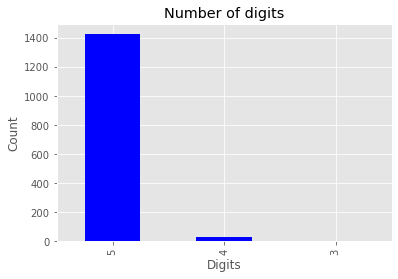

In [8]:
plates_plot['n_l'].value_counts().plot(kind = 'bar', color = 'blue');
plt.title('Number of digits');
plt.xlabel('Digits');
plt.ylabel('Count');

### Average price by # of digits

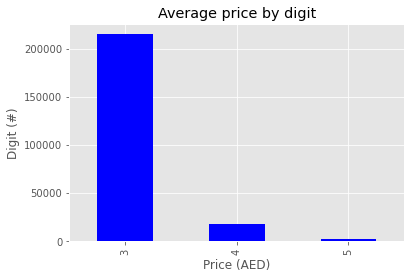

In [9]:
plates_plot.groupby(['n_l'])['Price'].mean().plot(kind = 'bar', color = 'blue');
plt.title('Average price by digit');
plt.xlabel('Price (AED)');
plt.ylabel('Digit (#)');

### Average price by letter

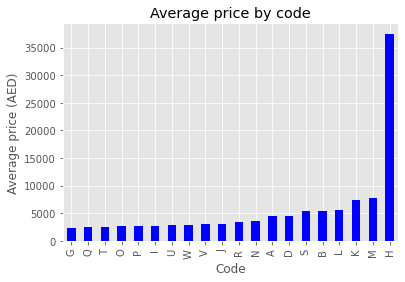

In [10]:
only_fives = plates_plot.loc[plates_plot['n_l'] == 5]

b_plot = only_fives.groupby(['Code'])['Price'].mean().sort_values()

b_plot.plot(kind = 'bar', color = 'blue');
plt.title('Average price by code');
plt.xlabel('Code');
plt.ylabel('Average price (AED)');

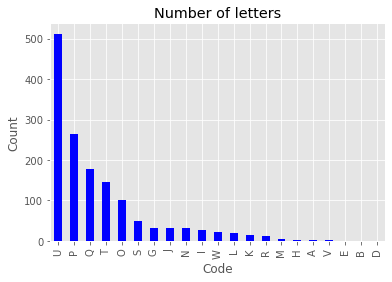

In [11]:
plates_plot['Code'].value_counts().plot(kind = 'bar', color = 'blue');
plt.title('Number of letters');
plt.xlabel('Code');
plt.ylabel('Count');

## Feature engineering

In [12]:
#Encode categorical values, turns letters into numbers
# Probably not gonna use this as a feature as it has almost no correlation with target
label_encoder = LabelEncoder()
plates['Code_encoded'] = label_encoder.fit_transform(plates['Code'])

#Mapping to use later for single data point prediction
label_map = {k:v for k,v in zip(label_encoder.classes_,range(len(label_encoder.classes_)))}

#### Shannon entropy

The Shannon Entropy is a measure of the expected value of information a message contains in bits. Number plates with more digits and less unique values tend to be pricier, but the more the unqiue digits the lesser the price, so the shannons entropy of the number plate might capture that pattern well.

$H(X) = -\Large\sum_{i=1}^{n}P_{r}(x_{i})(log_{b}P_{r}(x_{i}))$

In [13]:
def entropy(string):
    '''Calculates the Shannon entropy of a string'''
    
    prob = [ float(string.count(c)) / len(string) for c in dict.fromkeys(list(string)) ]
    return - sum(p * math.log(p) / math.log(2.0) for p in prob)

In [14]:
# Create features
# Adding in features that I think should capture buying patterns

plates['num_digits'] = plates_plot['Number'].apply(lambda x: len(x))
plates['unique_digits'] = plates_plot['Number'].apply(lambda x: len(set(x)))
plates['max_group'] = plates_plot['Number'].apply(lambda x: Counter(x).most_common(1)[0][1])
plates['shan_entrop'] = plates_plot['Number'].apply(entropy)
plates['number_int'] = plates_plot['Number'].astype(int)

# I am not normalizing data
#because it doesn't seem to me that that there will be that big of a difference
#due to the ranges of the features being small. However the num_int can have a large influence, which it should. 

# Normalized features for testing
# Code is going to be left commented out if performance is not better.

plates.head()

,Number,Code,Price,Code_encoded,num_digits,unique_digits,max_group,shan_entrop,number_int
0,274,I,215000,6,3,3,1,1.584963,274
1,78888,H,72000,5,5,2,4,0.721928,78888
2,6777,K,72000,8,4,2,3,0.811278,6777
3,3334,R,72000,15,4,2,3,0.811278,3334
4,22232,N,41000,11,5,2,4,0.721928,22232


### Feature plots

Looking at some plots of how the features correspond to the target might will help.

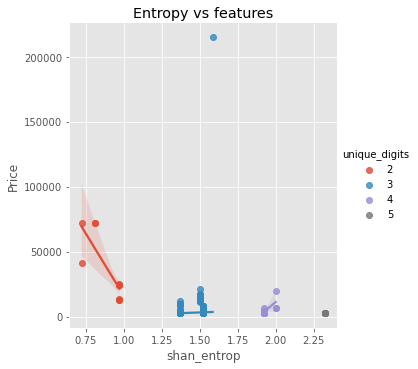

In [15]:
sns.lmplot(x = "shan_entrop", y = "Price", hue = "unique_digits", data = plates);
plt.title('Entropy vs features');

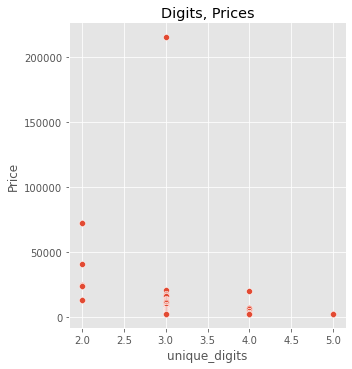

In [16]:
sns.relplot(x = "unique_digits", y = "Price", data = plates);
plt.title('Digits, Prices');

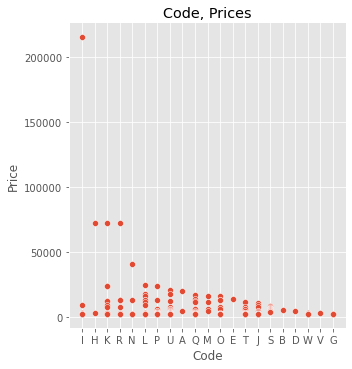

In [17]:
sns.relplot(x = "Code", y = "Price", data = plates);
plt.title('Code, Prices');

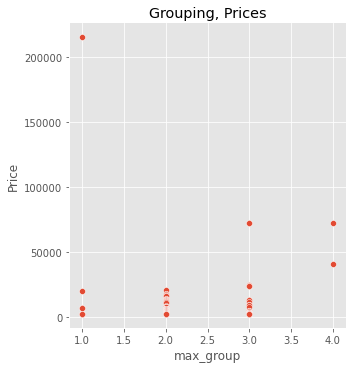

In [18]:
sns.relplot(x = "max_group", y = "Price", data = plates);
plt.title('Grouping, Prices');

### Price Distribution

I would consider normalizing it, but none of the algos I will use require it, so I'll skip that step in this case.

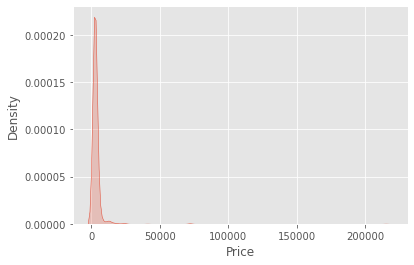

In [19]:
sns.kdeplot(plates["Price"], shade=True);

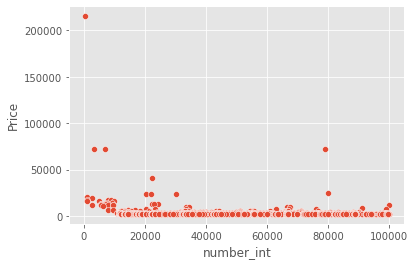

In [20]:
sns.scatterplot(x = 'number_int', y = 'Price', data = plates);

# Testing the different ML models

In [21]:
# Create X and Y
y = plates['Price']
features = ['unique_digits', 'shan_entrop','num_digits','max_group','number_int']
X = plates[features]

# normalizing inputs 
X = MinMaxScaler().fit(X).transform(X)

# Create the test train split
train_X, val_X, train_y, val_y = train_test_split(X, y,random_state = 0)

In [22]:
'''
Helper function to help train and evaluate models
Keep in mind this is VERY SIMPLE and just for testing, if we want to make things accurate..
We are going to have to do a lot more work, but at the end maybe we can
Squeeze out 3-4% more performance which I don't think is worth it.

'''
def test(model):
    model.fit(train_X, train_y)
    y_pred = model.predict(val_X)

    print(f'Mean absolute error = {mean_absolute_error(val_y, y_pred):.2f} AED')
    print(f'RMSE = {mean_squared_error(val_y, y_pred, squared = 0):.2f} AED')
    print(f'Model accuracy = {(1 - mean_absolute_percentage_error(val_y, y_pred))*100:.2f} %')
    
    model_name = re.findall(r'(?<=\.)[a-zA-Z]+(?=\')',str(model.__class__))[0]
    
    sns.scatterplot(x = val_y,y =  y_pred)
    plt.title(f'{model_name}')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')

##### Random Forest

Mean absolute error = 614.18 AED
RMSE = 2203.69 AED
Model accuracy = 90.28 %


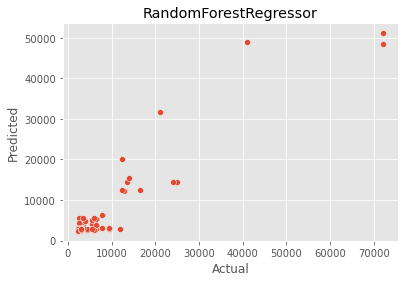

In [23]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(random_state=1)
test(forest_model)

##### XGB

Mean absolute error = 560.04 AED
RMSE = 1789.72 AED
Model accuracy = 89.70 %


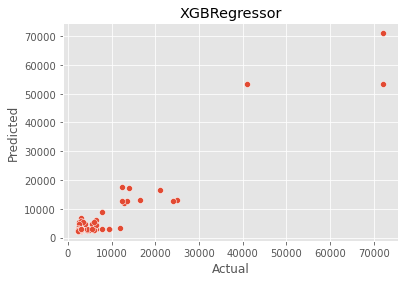

In [24]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor()
test(xgb_model)

##### Lin Reg

Mean absolute error = 1023.44 AED
RMSE = 3259.57 AED
Model accuracy = 81.16 %


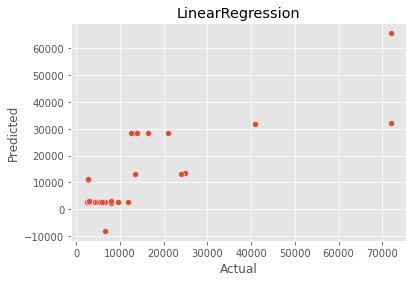

In [25]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()
test(linear_reg_model)

##### Decision Tree

Mean absolute error = 872.88 AED
RMSE = 1678.56 AED
Model accuracy = 90.21 %


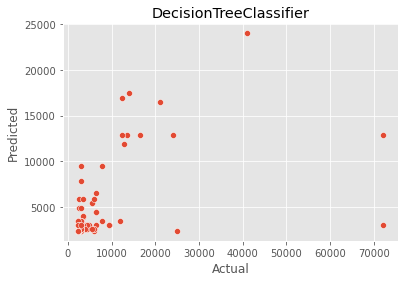

In [26]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier()
test(tree_model)

##### Neural network

Mean absolute error = 1018.08 AED
RMSE = 2433.68 AED
Model accuracy = 89.42 %


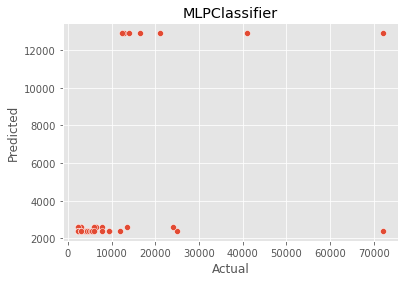

In [27]:
from sklearn.neural_network import MLPClassifier

nn_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10, 4), random_state=1)
test(nn_model)

##### KNN

Mean absolute error = 886.58 AED
RMSE = 1040.00 AED
Model accuracy = 90.62 %


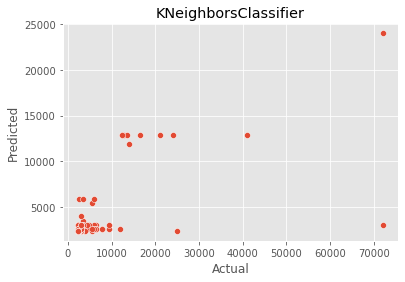

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors=3)
test(knn_model)

##### Ada boost

Mean absolute error = 687.67 AED
RMSE = 2671.42 AED
Model accuracy = 89.38 %


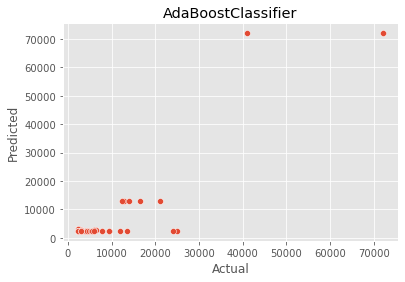

In [29]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(n_estimators=100, random_state=0)
test(ada_model)

__________________________________________________________

It seems to be XGBoost is the best model for predicting large values and Decision tree for small values. Given the MAE and RMSE values relatively.

So for values 5 digit plates I will use a decision tree and for below use XGBoost

TODO: Optimize the model and the preprocessing steps further.

_________________________________________

## Initial testing

Testing a function to predict one off prices, NOT A MODEL.

In [30]:
'''
I combined XGB and DecisionTree classifiers for large and small numbers to play to their strengths
For a small number we would want a model with a small mean absolute error, whilst for a large number we would 

'''

def predict_price(platenumber):
       
    code,number = platenumber.split('-')
    
    if len(number) not in range(2,6):
        return 'Invalid number plate'
    
    letter_num = label_map[code]
    
    d = {'number_int':[int(number)],
        'num_digits':[len(number)],
        'unique_digits':[len(set(number))],
        'shan_entrop':[entropy(number)],
        'max_group':[Counter(number).most_common(1)[0][1]]}
    
    val_X = pd.DataFrame(data = d)
    
    return_value = xgb_model.predict(val_X)[0]

    return f'Predicted price for plate {code}-{number} is {return_value:.2f} AED'        

In [31]:
predict_price('A-12345')

'Predicted price for plate A-12345 is 2298.11 AED'

In [32]:
predict_price('A-10000')

'Predicted price for plate A-10000 is 2298.11 AED'

In [33]:
predict_price('A-1234')

'Predicted price for plate A-1234 is 2298.11 AED'

In [34]:
predict_price('A-123')

'Predicted price for plate A-123 is 2298.11 AED'

In [35]:
predict_price('B-31256')

'Predicted price for plate B-31256 is 2298.11 AED'

Despite the relative high accuracy the models fail to predict accurately around outlier values due to the inherent nature of the data, thus just a pure old school ML algo might not be the best way to go ahead.

## Hyperparameter tuning

#### XGBoost

In [36]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [37]:
space={ 'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'alpha' : hp.quniform('reg_alpha', 40,180,1),
        'learning_rate' : 0.1,
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'n_estimators': 10
}

def objective(space):
    clf=XGBRegressor(
                    n_estimators =space['n_estimators'],
                    max_depth = int(space['max_depth']),
                    alpha = int(space['alpha']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    clf.fit(train_X, train_y)
    

    pred = clf.predict(val_X)
    accuracy = 1 - mean_absolute_error(val_y, pred)
    return {'loss': -accuracy, 'status': STATUS_OK }

trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

100%|██████████| 100/100 [00:03<00:00, 31.44trial/s, best loss: 945.2327141748716]


In [38]:
best_hyperparams

{'colsample_bytree': 0.7469971177485533, 'max_depth': 17.0, 'reg_alpha': 79.0}

In [39]:
model = XGBRegressor(colsample_bytree= 0.9380797469131581, max_depth = 4, reg_alpha = 45.0
                     ,learning_rate = 0.6, n_estimators = 100)
model.fit(train_X, train_y)
y_pred = model.predict(val_X)

print(f'Mean absolute error = {mean_absolute_error(val_y, y_pred):.2f} AED')
print(f'RMSE = {mean_squared_error(val_y, y_pred, squared = 0):.2f} AED')
print(f'Model accuracy = {(1 - mean_absolute_percentage_error(val_y, y_pred))*100:.2f} %')

Mean absolute error = 635.07 AED
RMSE = 2483.35 AED
Model accuracy = 89.44 %


It seems to me tuning parameters won't bring much benefits, probably the best thing to do would be to improve the feature engineering.

Howeverm I can try K-means clustering with the levenshtein distance as the distance metric and see how that performs. 

## Non ML methods

In [40]:
from Levenshtein import distance

### The Levenshtein distance


The Levenshtein distance between two words is the minimum number of single-character edits (insertions, deletions or substitutions) required to change one word into the other.

${\Large\displaystyle \qquad \operatorname {lev} (a,b)={\begin{cases}|a|&{\text{ if }}|b|=0,\\|b|&{\text{ if }}|a|=0,\\\operatorname {lev} (\operatorname {tail} (a),\operatorname {tail} (b))&{\text{ if }}a[0]=b[0]\\1+\min {\begin{cases}\operatorname {lev} (\operatorname {tail} (a),b)\\\operatorname {lev} (a,\operatorname {tail} (b))\\\operatorname {lev} (\operatorname {tail} (a),\operatorname {tail} (b))\\\end{cases}}&{\text{ otherwise.}}\end{cases}}}$

In [41]:
# Create X and Y for the Levenshtein training

features = ['num_digits','number_int','Price']
X_lev = plates[features]

# Create the test train split
train_X_lev, val_X_lev= train_test_split(X_lev,random_state = 0)

In [42]:
def lev_dist_minimizer(string):

    lev_plates = train_X_lev
    lev_plates['levenshtein'] = lev_plates['number_int'].apply(lambda row: distance(string,str(row)))

    same_size = lev_plates.loc[lev_plates['num_digits'] == len(string)]
    
    ret = same_size.loc[same_size['levenshtein'] == same_size['levenshtein'].min(),'Price']
    return ret.mean()

In [43]:
val_y_lev = val_X_lev['Price']
y_pred_lev = np.array([lev_dist_minimizer(str(x)) for x in val_X_lev['number_int']])

print(f'Mean absolute error = {mean_absolute_error(val_y_lev, y_pred_lev):.2f} AED')
print(f'RMSE = {mean_squared_error(val_y_lev, y_pred_lev, squared = 0):.2f} AED')
print(f'Model accuracy = {(1 - mean_absolute_percentage_error(val_y_lev, y_pred_lev))*100:.2f} %')

Mean absolute error = 942.79 AED
RMSE = 5533.36 AED
Model accuracy = 90.59 %


In [44]:
lev_dist_minimizer('12345')

2720.0

In [45]:
lev_dist_minimizer('1234')

42250.0

In [46]:
lev_dist_minimizer('123')

215000.0

This method seems to work well enough for a majority of the numbers, the accuracy is on par with the ML models, however I can see it being erroneous when predicting around outlier values because it would have a small levenshtein distance with it, but thats a shortcoming of ML based algorithms as well. 

## Clustering with Levenshtein as metric